# SPOTDisClust Demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import hdbscan
from spot import spot, tools

In the following descriptions, the term "epoch" is used synonymously with what you might call "trial" or "time window".

The data format that the Spike Pattern Optimal Transport Dissimilarity (SPOTDis) computation is based on consists of two data-structures:

1) The spike times vector (e.g. `spike_times = [0.2, 0.6, 0.65, 0.9, 1.1, 0.3, 0.9, 0.2]`) of type `float` with one entry for each spike.

2) The index matrix with the dimensions `(#epochs, #neurons, 2)` of type `int` where the last dimension contains a start and a stop index for the spike times vector, indicating which spikes belong to the selected epoch and neuron.
```
ii_spike_times = [
    # Epoch 1
    [
        # Neuron 1 -> spike(s) at time(s) 0.2, 0.6
        [0, 2],
        # Neuron 2 -> spike(s) at time(s) 0.65
        [2, 3],
        # Neuron 3 -> spike(s) at time(s) 0.9, 1.1
        [3, 5],
    ],
    # Epoch 2
    [
        # Neuron 1 -> spike(s) at time(s) 0.3
        [5, 6],
        # Neuron 2 -> spike(s) at time(s) 0.9
        [6, 7],
        # Neuron 3 -> spike(s) at time(s) 0.2
        [8, 9],
    ],
]
```
Therefore, the only requirement for the `spike_times` vector is that the spike times for a specific epoch and a specific neuron are listed consecutively. However, neurons or epochs do not need to be in any specific order.

The spike times for a given epoch `e` and neuron `n` can be retrieved from the spike times vector using the index matrix as follows:  
`epoch_neuron_spike_times = spike_times[ii_spike_times[e, n, 0]:ii_spike_times[e, n, 1]]`

In [2]:
spike_times = np.load('../example_data/spike_times_example.npy')
ii_spike_times = np.load('../example_data/ii_spike_times_example.npy')
epoch_labels = np.load('../example_data/epoch_labels_example.npy')

print('\nDemo data-set dimensions\n')
print('spike_times (#spikes): {}'.format(spike_times.shape))
print('ii_spike_times (#epochs x #neurons x 2): {}\n'.format(ii_spike_times.shape))


Demo data-set dimensions

spike_times (#spikes): (23769,)
ii_spike_times (#epochs x #neurons x 2): (180, 20, 2)



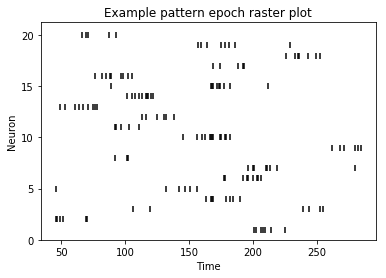

In [3]:
f, ax = plt.subplots()

ax.set_title('Example pattern epoch raster plot')

i_epoch = np.argmax(epoch_labels == 1)
n_neurons = ii_spike_times.shape[1]

for i_neuron in range(n_neurons):
    tmp_epoch_neuron_spike_times = spike_times[
        ii_spike_times[i_epoch, i_neuron, 0]:ii_spike_times[i_epoch, i_neuron, 1]]
    ax.scatter(tmp_epoch_neuron_spike_times, np.ones(len(tmp_epoch_neuron_spike_times))+i_neuron,
               marker='|', c='black')

ax.set_yticks(np.arange(0, n_neurons+1, 5))
ax.set_ylabel('Neuron')
ax.set_xlabel('Time');

The Spike Pattern Optimal Transport Dissimilarity can be computed between two neuron-pair full cross-correlations (`SPOTD_xcorr`), or directly between spike times of two neurons (`SPOTD_spikes`).  
For all of those computations, parallelization on a single CPU is available via the target `cpu`, while for `SPOTD_xcorr` the target `slurm` is available as well, to distribute the computation on a SLURM managed cluster. However, this requires the additional Python module `spotslurm` which can be distributed by the authors on request only, since it requires additional support and is unstable.

In [4]:
dissimilarities = spot.distances(spike_times, ii_spike_times, metric='SPOTD_xcorr', target='cpu')

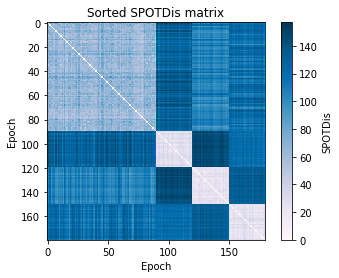

In [5]:
si = np.argsort(epoch_labels)
plt.title('Sorted SPOTDis matrix')
plt.imshow(dissimilarities[:, si][si], cmap='PuBu')
plt.colorbar().set_label('SPOTDis')
plt.xlabel('Epoch')
plt.ylabel('Epoch');

## HDBSCAN density clustering

A clustering method like HDBSCAN can be used to find clusters of epochs.

In [6]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
cluster_labels = clusterer.fit_predict(dissimilarities)

print(len(np.unique(cluster_labels)), 'clusters found')

4 clusters found


## 2D t-SNE embedding

A low-dimensional embedding technique like t-SNE can be used to visualize the epochs' relationship to one another.

In [7]:
embedding = TSNE(metric='precomputed', n_components=2).fit_transform(dissimilarities)

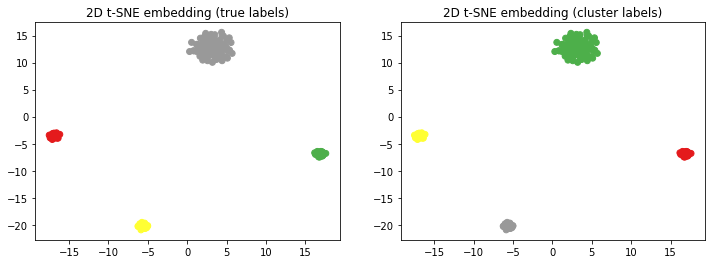

In [8]:
f, axa = plt.subplots(1, 2)
f.set_figwidth(12)

axa[0].set_title('2D t-SNE embedding (true labels)')
axa[0].scatter(embedding[:, 0], embedding[:, 1], cmap='Set1_r', c=epoch_labels)

axa[1].set_title('2D t-SNE embedding (cluster labels)')
axa[1].scatter(embedding[:, 0], embedding[:, 1], cmap='Set1_r', c=cluster_labels)

## Save cluster labels
Saves the cluster labels as a CSV for further use in other software environments.

In [10]:
np.savetxt('../example_data/cluster_labels_example.csv', cluster_labels, delimiter=',')